# Data Analysis on Airlines Delays

#### Goal :                                                                                                  
To analyse airlines delay data in USA and curve delays caused in major airlines between busiest routes which will give a fair idea to passengers about frequency of delays in general for a period of one year along with a particular airline and between a particular route. This will help customers for choosing a better airlines and taking a right call based on the weather for a particular region. Also,the same will also help airlines for better management and work on root cause of the delays.

#### Objective: 
To provide general descriptive analysis on delays and to analyse the root cause of delays.                                      To generate Predictive analysis in determining probabale delays in defined airlines and airports.                                To compare between different airlines and major airports with respect to delays and cancellation.

In [65]:
import unicodecsv  #importing csv
import pandas as pd #importing pandas
import numpy as np #importing numpy
import time #importing time
import matplotlib.pyplot as plt #importing matplotlib
import seaborn as sns #importing seaborn
import datetime as dt #importing datetime
from scipy import stats #importing scipy
from scipy.stats import norm
from os import walk
import time
%matplotlib inline
sns.set_style('whitegrid')

Source:
Airlines Data - Bureau of Transportation Statistics

### Data Cleaning of the dataset:

In [66]:
tic = time.time()
#Read all the airline data files
df = pd.DataFrame()

f = []
for (dirpath,dirnames,filenames) in walk('C:/Users/varap/OneDrive/Documents/Intro to DS/Project/27thNov/RawFiles/Monthly/'):
    f.extend(filenames)
    break

for file in f[1:]:
    df = df.append(pd.read_csv('C:/Users/varap/OneDrive/Documents/Intro to DS/Project/27thNov/RawFiles/Monthly/'+file))
    
toc = time.time()
print(toc-tic)

C:\Users\varap\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning:

Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.



108.68734526634216


In [67]:
df.head() #gives us the first 5 values of the dataset

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 39
0,2019,8,23,5,2019-08-23,WN,N7704B,528,15016,STL,...,196.0,181.0,1.0,1371.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2019,8,23,5,2019-08-23,WN,N8661A,2090,15016,STL,...,193.0,182.0,1.0,1371.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2019,8,23,5,2019-08-23,WN,N8672F,564,15016,STL,...,228.0,208.0,1.0,1592.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2019,8,23,5,2019-08-23,WN,N561WN,570,15016,STL,...,229.0,212.0,1.0,1592.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2019,8,23,5,2019-08-23,WN,N8608N,1841,15016,STL,...,226.0,210.0,1.0,1592.0,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
df.columns #gives us the name and number of columns of the dataset

Index(['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE',
       'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN', 'ORIGIN_CITY_NAME', 'DEST_AIRPORT_ID',
       'DEST', 'DEST_CITY_NAME', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY',
       'DEP_DELAY_NEW', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN',
       'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW', 'CANCELLED',
       'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS', 'DISTANCE',
       'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',
       'LATE_AIRCRAFT_DELAY', 'Unnamed: 39'],
      dtype='object')

In [69]:
#Read the Carrier Key CSV file for full names of the Airlines
carrier_key = pd.read_csv('C:/Users/varap/OneDrive/Documents/Intro to DS/Project/27thNov/RawFiles/airlines_desc.csv')

In [70]:
#Merge with the dataframe containing the 10 biggest Airline Carriers
df = pd.merge(df,carrier_key,how='left',left_on='OP_UNIQUE_CARRIER', right_on='OP_UNIQUE_CARRIER')

In [71]:
#Remove columns which are not used in analysis
df.drop(['ORIGIN_AIRPORT_ID','DEST_AIRPORT_ID','Unnamed: 39','DEP_DELAY','ARR_DELAY'],axis=1,inplace=True)

In [72]:
#Drop rows with missing data in the important columns, i.e. the predictors for flight delay
total_data_rows = len(df.index)
#Drop NaNs
df.dropna(subset = ['OP_UNIQUE_CARRIER','ORIGIN','DEST','CRS_DEP_TIME','CRS_ARR_TIME','ARR_DELAY_NEW','CRS_ELAPSED_TIME','DISTANCE'],inplace=True)
data_retained = len(df.index)/total_data_rows
print('Data Retained: '+str(round(data_retained*100,2))+' %')

Data Retained: 97.94 %


In [73]:
#Get the Departure and Arrival Hours
#For DEP_HOUR, take the CRS_DEP_TIME
df['DEP_HOUR'] = df['CRS_DEP_TIME'].apply(lambda x:int(str(x)[:2]) if x>999 else int(str(x)[:1] if x>99 else 0))
#For ARR_HOUR, take the actual arrival time
df['ARR_HOUR'] = df['ARR_TIME'].apply(lambda x:int(str(x)[:2]) if x>999 else int(str(x)[:1] if x>99 else 0))
df['ARR_HOUR'] = df['ARR_HOUR'].apply(lambda x:0 if x==24 else x)

In [74]:
df['TOTAL_DELAY'] = df['DEP_DELAY_NEW'] + df['ARR_DELAY_NEW'] # derving a new column 'total delay'.

In [75]:
df.fillna(0, inplace=True)# replacing NA Values

In [76]:
#we rename our column names  as ber business requirements
df.rename(columns= {'YEAR':'Year','MONTH':'Month','DAY_OF_MONTH':'Day_Of_Month','DAY_OF_WEEK':'Day_Of_Week','FL_DATE':'Flight_Date','OP_UNIQUE_CARRIER':'Carrier_Code','TAIL_NUM':'Tail_Number','OP_CARRIER_FL_NUM':'Flight_Number','ORIGIN':'Origin_Airport','ORIGIN_CITY_NAME':'Origin_City','DEST':'Destination_Airport','DEST_CITY_NAME':'Destination_City_Name','CRS_DEP_TIME':'Scheduled_departure_time','DEP_TIME':'Actual_departure_time','DEP_DELAY_NEW':'Departure_delay','TAXI_OUT':'Taxi-Out_Time','WHEELS_OFF':'Wheels-Off_Time','WHEELS_ON':'Wheels-On_Time','TAXI_IN':'Taxi-In_Time','CRS_ARR_TIME':'Scheduled_Arrival_time','ARR_TIME':'Actual_Arrival_Time','ARR_DELAY_NEW':'Arrival_Delay','CANCELLED':'Cancelled','CANCELLATION_CODE':'Cancellation_Code','DIVERTED':'Diverted','CRS_ELAPSED_TIME':'Scheduled_elapsed_time','ACTUAL_ELAPSED_TIME':'Actual_elapsed_time','AIR_TIME':'Air_Time','FLIGHTS'
:'Flights','DISTANCE':'Distance','DEP_HOUR':'Departure_Hour','ARR_HOUR':'Arrival_Hour','CARRIER_DELAY':'Carrier_Delay','WEATHER_DELAY':'Weather_Delay','LATE_AIRCRAFT_DELAY':'Late_Aircraft_Arrival_Delay','NAS_DELAY':'National_Aviation_System_Delay','SECURITY_DELAY':'Security_Delay','TOTAL_DELAY':'Total_Delay','Airlines_x':'Airlines'},inplace=True)

In [77]:
df.columns # gives us the number and names of columns

Index(['Year', 'Month', 'Day_Of_Month', 'Day_Of_Week', 'Flight_Date',
       'Carrier_Code', 'Tail_Number', 'Flight_Number', 'Origin_Airport',
       'Origin_City', 'Destination_Airport', 'Destination_City_Name',
       'Scheduled_departure_time', 'Actual_departure_time', 'Departure_delay',
       'Taxi-Out_Time', 'Wheels-Off_Time', 'Wheels-On_Time', 'Taxi-In_Time',
       'Scheduled_Arrival_time', 'Actual_Arrival_Time', 'Arrival_Delay',
       'Cancelled', 'Cancellation_Code', 'Diverted', 'Scheduled_elapsed_time',
       'Actual_elapsed_time', 'Air_Time', 'Flights', 'Distance',
       'Carrier_Delay', 'Weather_Delay', 'National_Aviation_System_Delay',
       'Security_Delay', 'Late_Aircraft_Arrival_Delay', 'Airlines',
       'Departure_Hour', 'Arrival_Hour', 'Total_Delay'],
      dtype='object')

In [78]:
# Sorting the data by Date Column in Ascending order:
df=df.sort_values(by=['Flight_Date'],ascending=True)
df[0:10]

,Year,Month,Day_Of_Month,Day_Of_Week,Flight_Date,Carrier_Code,Tail_Number,Flight_Number,Origin_Airport,Origin_City,...,Distance,Carrier_Delay,Weather_Delay,National_Aviation_System_Delay,Security_Delay,Late_Aircraft_Arrival_Delay,Airlines,Departure_Hour,Arrival_Hour,Total_Delay
6544859,2018,9,1,6,2018-09-01,AA,N187US,646,PHX,"Phoenix, AZ",...,2075.0,0.0,0.0,0.0,0.0,0.0,American Airlines,6,14,2.0
6642407,2018,9,1,6,2018-09-01,UA,N57868,223,SFO,"San Francisco, CA",...,967.0,0.0,0.0,0.0,0.0,0.0,United Air Lines,10,14,5.0
6642408,2018,9,1,6,2018-09-01,UA,N427UA,221,IAD,"Washington, DC",...,588.0,0.0,0.0,29.0,0.0,0.0,United Air Lines,12,14,62.0
6642409,2018,9,1,6,2018-09-01,UA,N17244,221,MCO,"Orlando, FL",...,758.0,0.0,0.0,0.0,0.0,0.0,United Air Lines,9,11,0.0
6642410,2018,9,1,6,2018-09-01,UA,N423UA,220,PIT,"Pittsburgh, PA",...,413.0,0.0,0.0,0.0,0.0,0.0,United Air Lines,17,18,0.0
6642411,2018,9,1,6,2018-09-01,UA,N211UA,219,ORD,"Chicago, IL",...,4243.0,0.0,36.0,38.0,0.0,0.0,United Air Lines,10,15,110.0
6642412,2018,9,1,6,2018-09-01,UA,N768UA,218,HNL,"Honolulu, HI",...,4243.0,0.0,0.0,0.0,0.0,0.0,United Air Lines,15,4,0.0
6642413,2018,9,1,6,2018-09-01,UA,N27722,217,ABQ,"Albuquerque, NM",...,1118.0,0.0,0.0,0.0,0.0,21.0,United Air Lines,13,17,59.0
6642414,2018,9,1,6,2018-09-01,UA,N12238,215,DCA,"Washington, DC",...,1208.0,0.0,0.0,0.0,0.0,0.0,United Air Lines,10,12,7.0
6642415,2018,9,1,6,2018-09-01,UA,N837UA,214,SEA,"Seattle, WA",...,679.0,0.0,0.0,0.0,0.0,0.0,United Air Lines,18,19,0.0


In [79]:
# Checking for duplicate Values
df.duplicated().sum()

0

#### Status represents wether the flight was on time (0), slightly delayed (1), highly delayed (2), diverted (3), or cancelled (4)

In [80]:
df.loc[df['Total_Delay'] <= 15, 'Status'] = 0
df.loc[df['Total_Delay'] >= 15, 'Status'] = 1
df.loc[df['Total_Delay'] >= 60, 'Status'] = 2
df.loc[df['Cancellation_Code'] == 1, 'Status'] = 3
df.loc[df['Carrier_Code'] == 'AA', 'CC'] = 1
df.loc[df['Carrier_Code'] == 'DL', 'CC'] = 2
df.loc[df['Carrier_Code'] == 'UA', 'CC'] = 3
df.loc[df['Carrier_Code'] == 'B6', 'CC'] = 4


In [81]:
df.head() # Gives us the firt 5 values of the dataset

,Year,Month,Day_Of_Month,Day_Of_Week,Flight_Date,Carrier_Code,Tail_Number,Flight_Number,Origin_Airport,Origin_City,...,Weather_Delay,National_Aviation_System_Delay,Security_Delay,Late_Aircraft_Arrival_Delay,Airlines,Departure_Hour,Arrival_Hour,Total_Delay,Status,CC
6544859,2018,9,1,6,2018-09-01,AA,N187US,646,PHX,"Phoenix, AZ",...,0.0,0.0,0.0,0.0,American Airlines,6,14,2.0,0.0,1.0
6642407,2018,9,1,6,2018-09-01,UA,N57868,223,SFO,"San Francisco, CA",...,0.0,0.0,0.0,0.0,United Air Lines,10,14,5.0,0.0,3.0
6642408,2018,9,1,6,2018-09-01,UA,N427UA,221,IAD,"Washington, DC",...,0.0,29.0,0.0,0.0,United Air Lines,12,14,62.0,2.0,3.0
6642409,2018,9,1,6,2018-09-01,UA,N17244,221,MCO,"Orlando, FL",...,0.0,0.0,0.0,0.0,United Air Lines,9,11,0.0,0.0,3.0
6642410,2018,9,1,6,2018-09-01,UA,N423UA,220,PIT,"Pittsburgh, PA",...,0.0,0.0,0.0,0.0,United Air Lines,17,18,0.0,0.0,3.0


# Exploratory Data Analysis:

## Density Plot and Histogram of Flight Delays

It can be seen on the histogram and by the skewness and kurtosis indexes, that delays are mostly located on the left side of the graph, with a long tail to the right. The majority of delays are short, and the longer delays, while unusual, are more heavy loaded in time

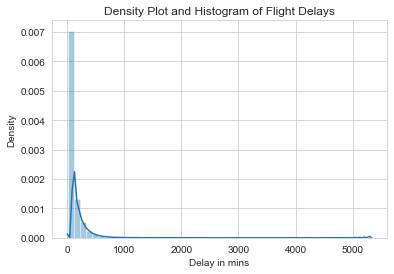

In [82]:
Delayedflights = df[(df.Status >= 1) &(df.Status < 3)] 
sns.distplot(Delayedflights['Total_Delay']) #creating the density plot of flight delays
plt.xlabel('Delay in mins') #the name of the x axis of the graph
plt.ylabel('Density')     #the name of the y axis of the graph
plt.title('Density Plot and Histogram of Flight Delays') # the name of the title of the graph
plt.show()

In [83]:
print("Skewness: %f" % Delayedflights['Arrival_Delay'].skew()) #gives us the skewness indexes of arrival delay
print("Kurtosis: %f" % Delayedflights['Arrival_Delay'].kurt()) #gives us the Kurtosis indexes of the arrival delay

Skewness: 6.157955
Kurtosis: 63.429013


In [88]:
flights_by_carrier = df.pivot_table(index='Month', columns='Carrier_Code', values='Flight_Number', aggfunc='count')
flights_by_carrier.head()

Carrier_Code,9E,AA,AS,B6,DL,EV,F9,G4,HA,MQ,NK,OH,OO,UA,WN,YV,YX
Month,,,,,,,,,,,,,,,,,
1,19821,75354,20204,23395,73403,12200,9490,6694,6785,23710,15009,22369,61770,46126,107235,17829,24569
2,17633,70032,18039,21983,67117,10880,8633,7157,6014,21813,13436,20366,56394,43441,94683,15909,22784
3,22153,78222,21382,25449,84065,12467,9654,10203,6846,26312,17020,23991,68564,52912,113993,18378,26894
5,20830,78648,22408,24787,85357,8705,11230,8982,7215,27679,17762,24182,70598,53714,113341,18540,27361
6,21236,76068,23013,24083,86845,9129,11307,10987,7163,27020,17493,24079,70903,53454,112463,18798,26846


In [89]:
df.pivot_table(columns='Month')

Month,1,2,3,5,6,7,8,9,10,11,12
Actual_Arrival_Time,1484.411454,1484.591675,1473.719904,1457.633327,1442.386336,1439.404596,1449.148259,1471.822964,1478.075480,1472.586063,1475.807827
Actual_departure_time,1331.830093,1335.638468,1337.911954,1336.727078,1340.281789,1335.440459,1334.051857,1327.863669,1328.592734,1330.923044,1332.735957
Actual_elapsed_time,138.610077,139.499270,137.588820,136.251471,137.654720,136.769889,136.273147,134.149109,133.943714,136.310305,138.583747
Air_Time,112.694461,113.293482,113.103034,111.528657,112.056733,111.459666,110.572536,109.527906,109.430618,111.182232,113.391165
Arrival_Delay,13.654539,17.064703,12.164191,15.268918,18.944001,16.990512,15.783681,11.591981,11.003601,13.170264,12.308557
Arrival_Hour,14.537343,14.538415,14.428566,14.268135,14.114620,14.084965,14.181624,14.412356,14.475795,14.420028,14.450851
CC,2.080457,2.085772,2.106330,2.101606,2.106267,2.105381,2.100329,2.119999,2.111299,2.115020,2.120672
Cancellation_Code,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Cancelled,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Carrier_Delay,3.738057,4.748992,3.879746,4.060640,5.077792,4.772949,4.392318,3.129564,3.127243,3.633771,3.640958


In [90]:
delays_list = ['Carrier_Code','Weather_Delay','Late_Aircraft_Arrival_Delay','National_Aviation_System_Delay','Security_Delay']
flight_delays_by_day = df.pivot_table(index='Month', values=delays_list, aggfunc='sum')

### Relative Distribution of Delays

The Graph shows various causes of delays oveer a period of time and we can observe that the maximum number of delays have occured during the month of June

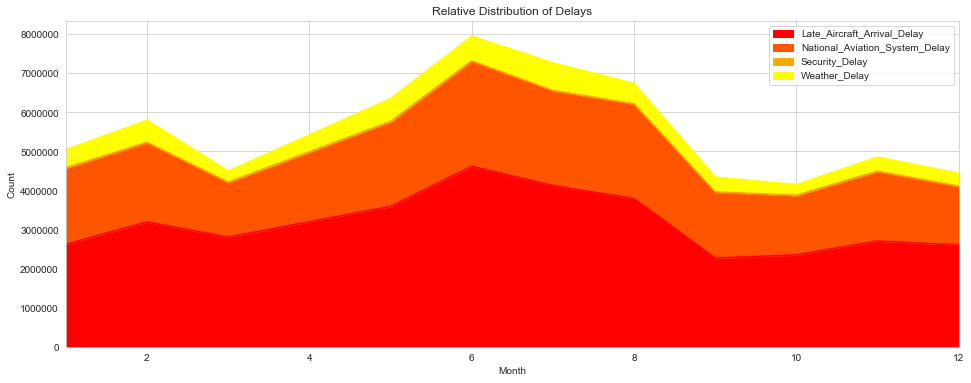

In [96]:
flight_delays_by_day.plot(kind='area', figsize=[16,6], stacked=True, colormap='autumn') # area plot
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Relative Distribution of Delays')
plt.legend()
plt.show()

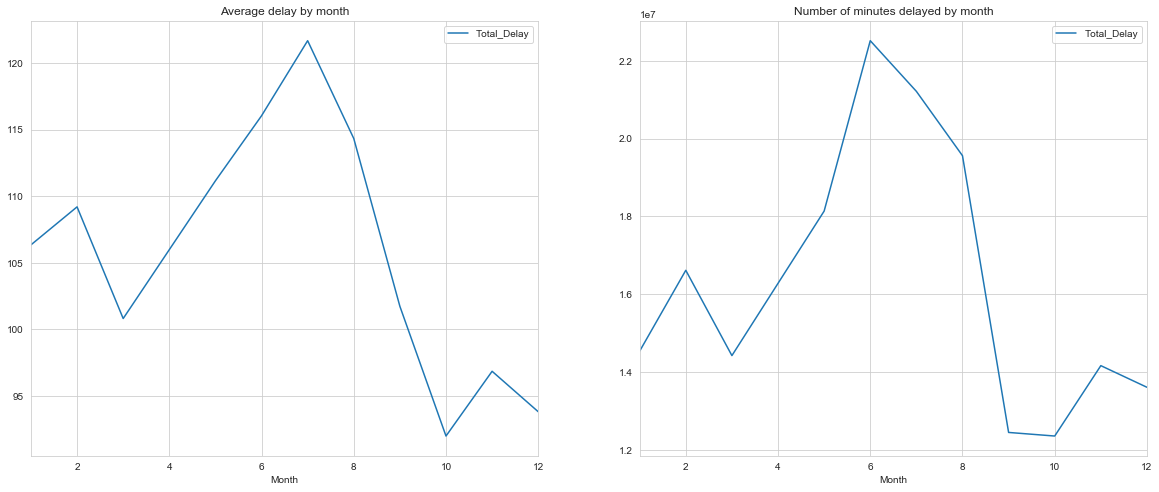

In [97]:
f,ax=plt.subplots(1,2,figsize=(20,8))
Delayedflights[['Month','Total_Delay']].groupby(['Month']).mean().plot(ax=ax[0])
ax[0].set_title('Average delay by month')
Delayedflights[['Month','Total_Delay']].groupby(['Month']).sum().plot(ax=ax[1])
ax[1].set_title('Number of minutes delayed by month')
plt.show()

### Corelation matix:

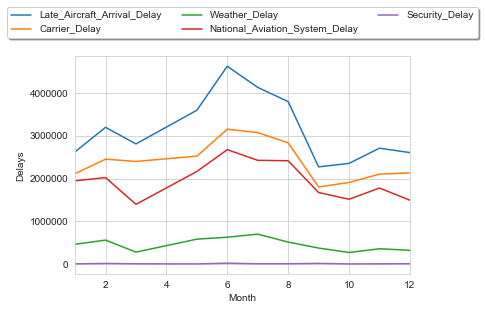

In [99]:
df = Delayedflights.filter(['Month','Carrier_Delay','Weather_Delay','Late_Aircraft_Arrival_Delay','National_Aviation_System_Delay','Security_Delay'], axis=1)
df = df.groupby('Month')['Late_Aircraft_Arrival_Delay','Carrier_Delay','Weather_Delay','National_Aviation_System_Delay','Security_Delay'].sum().plot()
df.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3, fancybox=True, shadow=True)
plt.xlabel('Month')
plt.ylabel('Delays')
plt.show()

The correlation matrix identifies three main variables for delays: Late Aircraft Delay, Carrier Delay and NAS Delay. The graph corroborates this assumption, showing how those three variables create most of delays during the year.

## Delays v/s Airlines

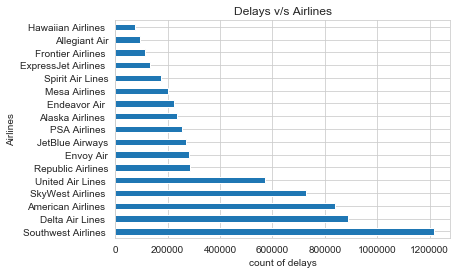

In [20]:
df['Airlines'].value_counts()[:20].plot(kind='barh') #creating bargraph for delays vs the airlines
plt.xlabel('count of delays') #Naming the X axis
plt.ylabel('Airlines')        #Naming the Y axis
plt.title('Delays v/s Airlines') #Naming the title
plt.show() # printing the output

### Delayed flights by carrier

Here, you can see airlines 'Southwest Airlines' has maximum delays in the past one year

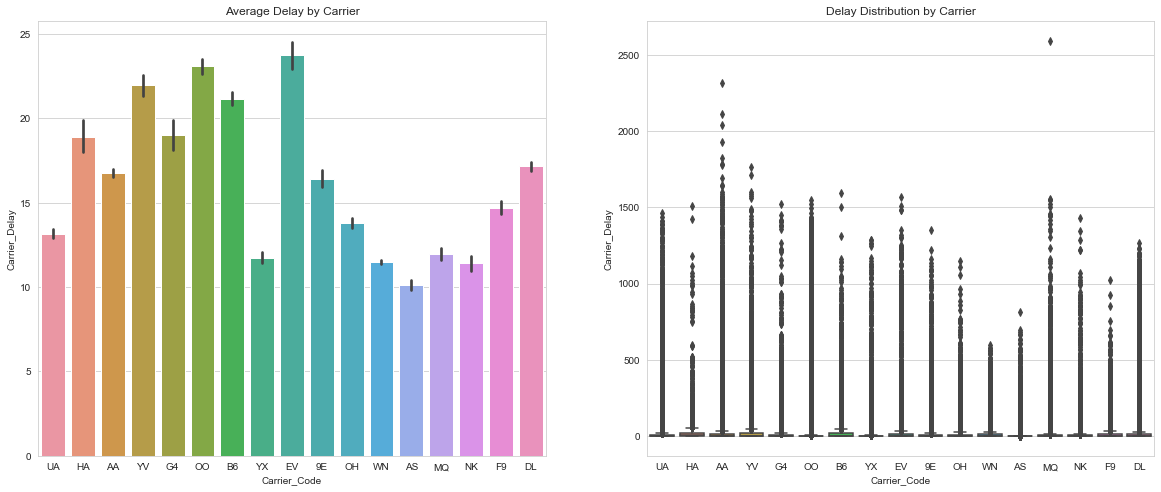

In [21]:
#creating the barplot and boxplot of delayed flights by carrier
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.barplot('Carrier_Code','Carrier_Delay', data=Delayedflights,ax=ax[0]) #gives us the barplot of delayed flights
ax[0].set_title('Average Delay by Carrier') #naming the title of the barplot
sns.boxplot('Carrier_Code','Carrier_Delay', data=Delayedflights,ax=ax[1]) #gives us the boxplot of delayed flights
ax[1].set_title('Delay Distribution by Carrier') #naming the title of boxplot 
plt.close(2)
plt.show()


### Delayed flights by the origin airport

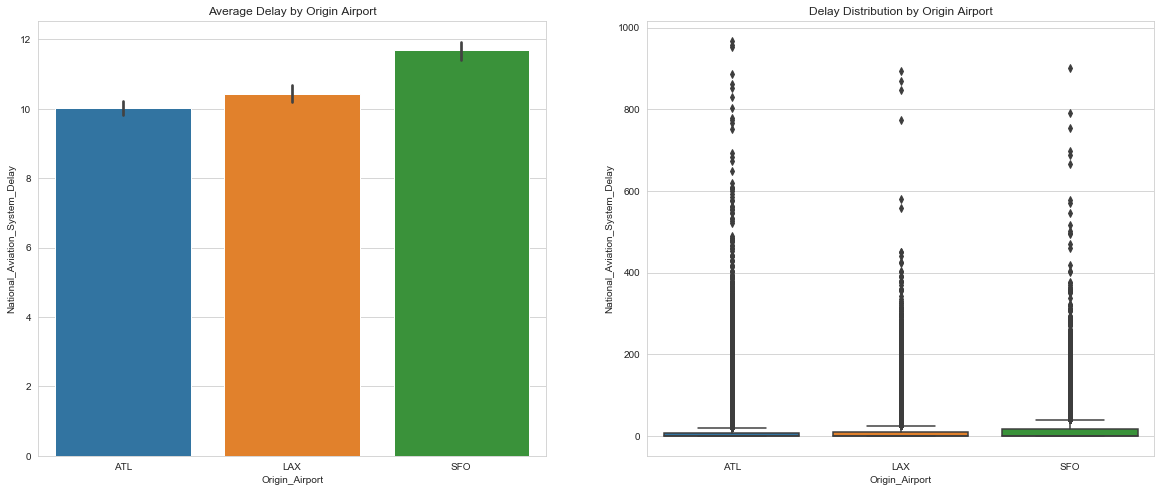

In [22]:
#Filtering the delayed flights by the origin airport for analysis
ListOfAirports = Delayedflights[(Delayedflights.Origin_Airport == 'ATL') | (Delayedflights.Origin_Airport == 'LAX') | (Delayedflights.Origin_Airport == 'SFO')]
f,ax=plt.subplots(1,2,figsize=(20,8)) #creating the plots
sns.barplot('Origin_Airport','National_Aviation_System_Delay', data=ListOfAirports,ax=ax[0]) # creating a bargraph
ax[0].set_title('Average Delay by Origin Airport') #naming the title
sns.boxplot('Origin_Airport','National_Aviation_System_Delay', data=ListOfAirports,ax=ax[1])# creating a boxplot
ax[1].set_title('Delay Distribution by Origin Airport') #naming the boxplot
plt.close(2)
plt.show() # giving us the output of the graph

### Flight arrival time performance:

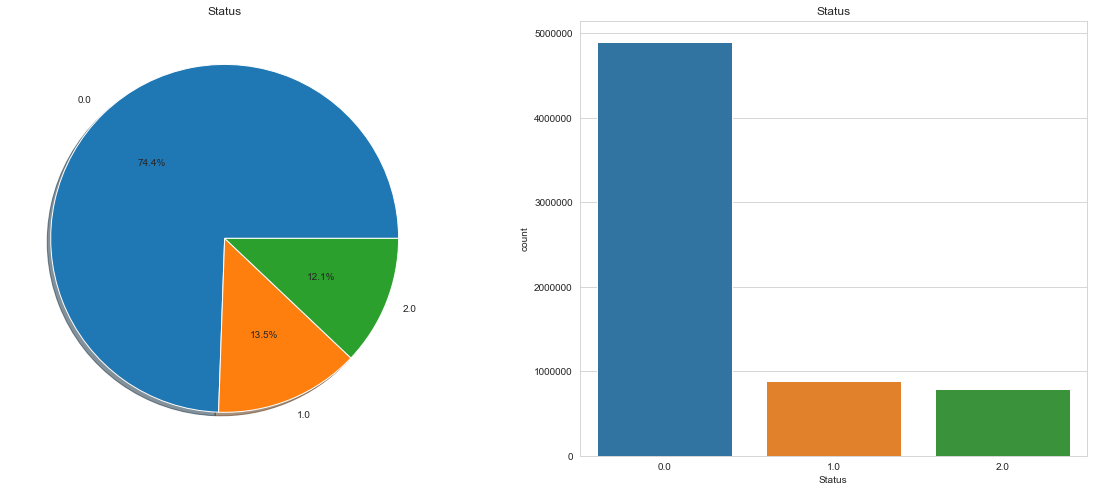

Status represents whether the flight was on time (0), slightly delayed (1), highly delayed (2), or cancelled (3)


In [23]:
#creating plot to show the status of the flight arrival time performance 
f,ax=plt.subplots(1,2,figsize=(20,8))
df['Status'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Status') #name of the title
ax[0].set_ylabel('') #name of the y axis
sns.countplot('Status',order = df['Status'].value_counts().index, data=df,ax=ax[1])
ax[1].set_title('Status') #name of the title 
plt.show()

print('Status represents whether the flight was on time (0), slightly delayed (1), highly delayed (2), or cancelled (3)')

In [24]:
#Total number of flights in our dataset:
len(df.index)

6583208

In [25]:
#Average number of flights per day in 2019:
len(df[df['Year']==2019].index)/365

11594.90410958904

In [26]:
#Percent of flights with delays greater than 15 minutes:
len(df[df['Arrival_Delay']>15].index)/len(df.index)

0.1902997748210295

In [27]:
#Head of the data:
df.head()

,Year,Month,Day_Of_Month,Day_Of_Week,Flight_Date,Carrier_Code,Tail_Number,Flight_Number,Origin_Airport,Origin_City,...,Weather_Delay,National_Aviation_System_Delay,Security_Delay,Late_Aircraft_Arrival_Delay,Airlines,Departure_Hour,Arrival_Hour,Total_Delay,Status,CC
6544859,2018,9,1,6,2018-09-01,AA,N187US,646,PHX,"Phoenix, AZ",...,0.0,0.0,0.0,0.0,American Airlines,6,14,2.0,0.0,1.0
6642407,2018,9,1,6,2018-09-01,UA,N57868,223,SFO,"San Francisco, CA",...,0.0,0.0,0.0,0.0,United Air Lines,10,14,5.0,0.0,3.0
6642408,2018,9,1,6,2018-09-01,UA,N427UA,221,IAD,"Washington, DC",...,0.0,29.0,0.0,0.0,United Air Lines,12,14,62.0,2.0,3.0
6642409,2018,9,1,6,2018-09-01,UA,N17244,221,MCO,"Orlando, FL",...,0.0,0.0,0.0,0.0,United Air Lines,9,11,0.0,0.0,3.0
6642410,2018,9,1,6,2018-09-01,UA,N423UA,220,PIT,"Pittsburgh, PA",...,0.0,0.0,0.0,0.0,United Air Lines,17,18,0.0,0.0,3.0


#### Visualize the Arrival Delays for top 10 airlines

In [28]:
#Visualize the Arrival Delays for top 10 airlines

#Get the list of the 10 biggest Airline Carriers
top10_carrier = list(df['Airlines'].value_counts().head(10).index)
df_sub = df[df['Airlines'].isin(top10_carrier)][['Airlines','Origin_Airport','Destination_Airport','Arrival_Delay']]
df_sub['Airlines'].unique()

array(['American Airlines ', 'United Air Lines ', 'Republic Airlines',
       'SkyWest Airlines ', 'JetBlue Airways', 'PSA Airlines ',
       'Southwest Airlines ', 'Alaska Airlines ', 'Envoy Air',
       'Delta Air Lines '], dtype=object)

In [29]:
#Create a copy of the dataframe for bar plot. Delays greater than 30 minutes are clubbed to show the data at the same scale
df_temp = df_sub.copy()
#All delays greater than 30 minutes are clubbed at 30
df_temp['Arrival_Delay'] = df_temp['Arrival_Delay'].apply(lambda x:30 if x>=30 else x)
df_temp['Arrival_Delay'] = df_temp['Arrival_Delay'].apply(lambda x:-30 if x<=-30 else x)

In [30]:
#Plot percentage of flights delayed more than 30 minutes

carrier_delay = pd.DataFrame()

for AA in list(df_temp['Airlines'].unique()):
    perc_delayed = len(df_temp[(df_temp['Airlines']==AA) & (df_temp['Arrival_Delay']>=30)].index)/len(df_temp[df_temp['Airlines']==AA].index)*100
    carrier_delay = carrier_delay.append({'Airlines':AA,'percent_delayed' : perc_delayed},ignore_index=True)

# carrier_delay = pd.merge(carrier_delay,carrier_key,how='left',left_on='OP_UNIQUE_CARRIER', right_on='Code')
#carrier_delay.drop(['OP_UNIQUE_CARRIER','Code'],axis=1,inplace=True)
#carrier_delay.rename(index=str,columns={'OP_UNIQUE_CARRIER':'Airline'},inplace=True)
#Sort by percentage delayed
carrier_delay.sort_values(by = ['percent_delayed'],ascending=False,inplace=True)

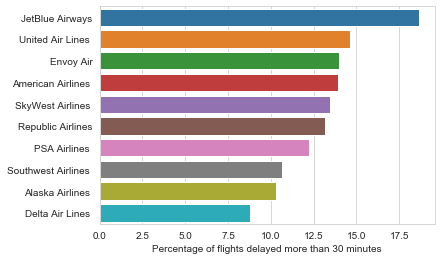

In [31]:
color_pal = sns.color_palette("OrRd", len(carrier_delay.index))
color_pal = color_pal[::-1]

plt.figure(figsize=(6, 4))
g = sns.barplot(x="percent_delayed", y="Airlines", data=carrier_delay)
g.set_ylabel('')
g.set_xlabel('Percentage of flights delayed more than 30 minutes')
fig = g.get_figure()
fig.savefig("carrier_delay.png", bbox_inches='tight')

As see above, most flights tend to arrive on or before time. But still, a big chunk of flights do get delayed by more than 15 minutes. Which airlines have the worst records of delays greater than 15 minutes?

JetBlue Airways (B6) is the worst performer, with 19.2% of its flights delayed more than 15 minutes, followed by ExpressJet Airlines (EV) 17.5% and Frontier Airlines (F9) 16.45%. Hawaiian Airlines(HA) and Delta Airlines(DL) are the best performers, with only 5.2% and 17.7% of their flights delayed more than 15 minutes respectively.

# Airports by Traffic

 We selected the 50 airports with the highest air traffic. Approximately 62% of the entire dataset originated and terminated in the top 50 airports.

In [32]:
#Create a new dataframe combining the Arrival and Destination Airports in one column
df_airport = pd.DataFrame(pd.concat([df['Origin_Airport'],df['Destination_Airport']]),columns={'IATA'})

In [33]:
#Select the Top 50 Airports 
df_top50 = pd.DataFrame(df_airport['IATA'].value_counts().head(50)).reset_index()
df_top50.rename(index=str, columns={"index":"IATA","IATA":"Count"},inplace=True)
del df_airport

In [34]:
#Read Airport data
df_airports = pd.read_csv('C:/Users/varap/OneDrive/Documents/Intro to DS/Project/27thNov/RawFiles/airports.dat')

In [35]:
df_airports = df_airports[df_airports['Country']=='United States'][['IATA','Latitude','Longitude']].copy()

In [36]:
#Merge with the DataFrame containing the list of Top 50 Airports
df_top50 = pd.merge(df_top50,df_airports,how='left',on="IATA")

In [37]:
import chart_studio
import plotly as py
# import chart_studio.plotly as plt
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
import plotly.graph_objs as go
import ipywidgets as widgets
from scipy import special
py.offline.init_notebook_mode(connected=True)

In [38]:
#Map the Airports as a Bubble map, with size corresponding to Traffic

#First create a new columns with Textual information
df_top50['text'] = df_top50['IATA'] + '<br>Total Flights: ' + (df_top50['Count']/1e3).astype(str)+' (Thousands)'

#Create plot using Plotly
limits = [(0,10),(11,30),(31,50)]
colors = ["rgb(0,116,217)","rgb(255,65,54)","rgb(133,20,75)"]
names = ["Top 10 Busiest","11-30","31-50"]
cities = []
scale = 2500

for i in range(len(limits)):
    lim = limits[i]
    df_sub = df_top50[lim[0]:lim[1]]
    city = dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = df_sub['Longitude'],
        lat = df_sub['Latitude'],
        text = df_sub['text'],
        marker = dict(
            size = df_sub['Count']/scale,
            color = colors[i],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name = names[i] )
    cities.append(city)
    
layout = dict(
        title = 'Top 50 Busiest Airports by Traffic',
        showlegend = True,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = go.Figure( data=cities, layout=layout )
py.offline.iplot(fig)

# look how to create credentials for iplot


The Top 50 airlines by traffic includes the arrival and departure delays.

### Machine Learning model to predict airline delay

In [39]:
import pandas as pd
import numpy as np
import time
from sklearn.externals import joblib

C:\Users\varap\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [40]:
# Considering RUNWAY_TOTAL_TIME as one of the predictor variables as total airplane time in the ground can cause delays

In [41]:
df['TOT'] = df['Wheels-On_Time'] - df['Wheels-Off_Time']
df['RUNAWAY_TOTAL_TIME'] = df['TOT'].floordiv(100)*60 + df['TOT'] - df['TOT'].floordiv(100)*100- df['Air_Time']

In [42]:
# Creating this to consider 'NAS' delay and 'Weather' as one more predictor variable
df['Delay_weather/traffic'] = df['National_Aviation_System_Delay'] + df['Weather_Delay']

In [43]:
# df['TOTAL_DELAY'] = df['Departure_delay'] + df['Arrival_Delay']

In [46]:
df[df['Total_Delay']<0] = 0

In [47]:
df_sub = df.copy()

In [48]:
df_sub.drop(['Flight_Date','Carrier_Code','Airlines', 'Tail_Number', 'Flight_Number', 'Origin_Airport','Origin_City', 'Destination_Airport', 'Destination_City_Name','Scheduled_departure_time', 'Actual_departure_time', 'Departure_delay','Taxi-Out_Time', 'Taxi-In_Time','Scheduled_Arrival_time', 'Actual_Arrival_Time', 'Arrival_Delay','Cancelled', 'Cancellation_Code', 'Diverted', 'Scheduled_elapsed_time','Flights', 'Distance','Actual_elapsed_time','Flights','Distance','Weather_Delay','National_Aviation_System_Delay','Late_Aircraft_Arrival_Delay','TOT'],axis=1,inplace=True)

Above, we have removed all the unwanted columns along with WHEELS_ON, WHEELS_OFF, NAS_DELAY, WEATHER_DELAY as those are made combined into 'RUNAWAY_TOTAL_TIME' and ''Delay_weather/traffic' respectively and also 'DEP_DELAY_NEW' and ARR_DELAY_NEW' as both are combined to give us the total delay taht would act as the dependent variable.Taxi in time also not required because
it has been calculated in the Runway total time itself. as Taxi time is the total time of an aircrafts movement on the
ground

In [49]:
#Checking head and tail 
df_sub.head(5)

,Year,Month,Day_Of_Month,Day_Of_Week,Wheels-Off_Time,Wheels-On_Time,Air_Time,Carrier_Delay,Security_Delay,Departure_Hour,Arrival_Hour,Total_Delay,Status,CC,RUNAWAY_TOTAL_TIME,Delay_weather/traffic
6544859,2018,9,1,6,701.0,1417.0,256.0,0.0,0.0,6,14,2.0,0.0,1.0,180.0,0.0
6642407,2018,9,1,6,1104.0,1401.0,117.0,0.0,0.0,10,14,5.0,0.0,3.0,100.0,0.0
6642408,2018,9,1,6,1331.0,1356.0,85.0,0.0,0.0,12,14,62.0,2.0,3.0,-60.0,29.0
6642409,2018,9,1,6,927.0,1108.0,101.0,0.0,0.0,9,11,0.0,0.0,3.0,40.0,0.0
6642410,2018,9,1,6,1754.0,1757.0,63.0,0.0,0.0,17,18,0.0,0.0,3.0,-60.0,0.0


In [50]:
df_sub.tail(5)

,Year,Month,Day_Of_Month,Day_Of_Week,Wheels-Off_Time,Wheels-On_Time,Air_Time,Carrier_Delay,Security_Delay,Departure_Hour,Arrival_Hour,Total_Delay,Status,CC,RUNAWAY_TOTAL_TIME,Delay_weather/traffic
244478,2019,8,31,6,1633.0,1817.0,164.0,16.0,0.0,15,18,52.0,1.0,1.0,-20.0,0.0
244509,2019,8,31,6,749.0,828.0,99.0,0.0,0.0,7,8,0.0,0.0,1.0,-20.0,0.0
244540,2019,8,31,6,1613.0,1906.0,353.0,0.0,0.0,16,19,0.0,0.0,1.0,-140.0,0.0
244638,2019,8,31,6,1623.0,1719.0,56.0,107.0,0.0,14,17,235.0,2.0,1.0,40.0,21.0
341892,2019,8,31,6,1023.0,1204.0,101.0,0.0,0.0,10,12,3.0,0.0,2.0,40.0,0.0


In [51]:
df.shape

(6583208, 44)

In [52]:
##### Droping rows with negative values in runway_total_time since it would be incorrect values
df_sub.drop(df_sub[df_sub.RUNAWAY_TOTAL_TIME < 0].index, inplace=True)

In [53]:
#Checking shape to see if rows with negative values are gone
df_sub.shape

(4836965, 16)

In [54]:
#Confirming rows with negative values are gone.
df_sub.tail()

,Year,Month,Day_Of_Month,Day_Of_Week,Wheels-Off_Time,Wheels-On_Time,Air_Time,Carrier_Delay,Security_Delay,Departure_Hour,Arrival_Hour,Total_Delay,Status,CC,RUNAWAY_TOTAL_TIME,Delay_weather/traffic
244201,2019,8,31,6,1345.0,1435.0,50.0,0.0,0.0,13,14,0.0,0.0,1.0,40.0,0.0
244280,2019,8,31,6,718.0,1232.0,194.0,0.0,0.0,7,12,8.0,0.0,1.0,120.0,0.0
244395,2019,8,31,6,1356.0,1453.0,57.0,0.0,0.0,13,15,0.0,0.0,1.0,40.0,0.0
244638,2019,8,31,6,1623.0,1719.0,56.0,107.0,0.0,14,17,235.0,2.0,1.0,40.0,21.0
341892,2019,8,31,6,1023.0,1204.0,101.0,0.0,0.0,10,12,3.0,0.0,2.0,40.0,0.0


In [55]:
#Defining X and Y to run the OLS model
X = df_sub[['Carrier_Delay','Security_Delay','RUNAWAY_TOTAL_TIME','Delay_weather/traffic']]
Y = df_sub['Total_Delay']

In [56]:
#Checking for Multicollinearity using vif 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

Carrier_Delay            1.008268
Security_Delay           1.000103
RUNAWAY_TOTAL_TIME       1.018827
Delay_weather/traffic    1.011761
dtype: float64

We could see vif is less then 5 for all the predictor variables, so we do not need to worry about multicollinearity

In [57]:
#Splitting the dataset into test and train sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.4)

In [58]:
import statsmodels.api as sm
model = sm.OLS(y_train,x_train)
result = model.fit()

In [59]:
#Coefficients
result.params

Carrier_Delay            2.118852
Security_Delay           2.179489
RUNAWAY_TOTAL_TIME       0.103243
Delay_weather/traffic    2.009807
dtype: float64

In [60]:
predictions = result.predict(x_test)

In [61]:
# Predictions from the model using x_test data
predictions

946132       0.000000
2331916      0.000000
3819628     10.324296
2373155      4.129718
5355665      4.129718
6706495      4.129718
3105653      6.194577
2489917      8.475406
3676911      0.000000
473890      22.713451
3923651     16.518873
5834871     10.324296
2270430      4.129718
5744901     42.316054
1371749     10.324296
6076276      0.000000
2345681      0.000000
1705259      0.000000
5770387      6.194577
1365830     65.576414
3932931      0.000000
2143412     10.324296
2643497    180.803659
3738004      0.000000
4719123      0.000000
1047409     10.324296
724640       0.000000
3606278     10.324296
3430455      4.129718
2057735    850.853049
              ...    
4618558      4.129718
103012       0.000000
1876024      4.129718
4009093      0.000000
1298688     18.583732
4994894      4.129718
997259       0.000000
5739514     10.324296
1017696     64.968096
257490       4.129718
876926      10.324296
6657782      0.000000
2609622     16.518873
5697360      8.204385
6271323   

In [62]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            Total_Delay   R-squared (uncentered):                   0.720
Model:                            OLS   Adj. R-squared (uncentered):              0.720
Method:                 Least Squares   F-statistic:                          1.861e+06
Date:                Fri, 13 Dec 2019   Prob (F-statistic):                        0.00
Time:                        19:10:06   Log-Likelihood:                     -1.5477e+07
No. Observations:             2902179   AIC:                                  3.095e+07
Df Residuals:                 2902175   BIC:                                  3.095e+07
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Carrier_Delay             2.1189      0.001   2090.563      0.000       2.117       2.121
Security_Delay            2.1795      0.018    120.667      0.000       2.144       2.215
RUNAWAY_TOTAL_TIME        0.1032      0.000    231.537      0.000       0.102       0.104
Delay_weather/traffic     2.0098      0.001   1602.132      0.000       2.007       2.012
==============================================================================
Omnibus:                  4812539.492   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       8417552202.708
Skew:                          10.913   Prob(JB):                         0.00
Kurtosis:                     265.933   Cond. No.                         41.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interferences:                                                                                                                  Omnibus/Prob(Omnibus) – a test of the skewness and kurtosis of the residual. We hope to see a value close to zero which         would indicate normalcy. And it is zero in our summary.
    Skew – a measure of data symmetry. We want to see something close to zero, but large majority of responses are near zero 
    so, we are getting a greater value. Future scope in this case is that it could be solved by log-transform.
    Kurtosis – a measure of "peakiness", or curvature of the data. Higher peaks lead to greater Kurtosis. Greater Kurtosis 
    can be interpreted as a tighter clustering of residuals around zero, implying a better model with few outliers.
    Durbin-Watson – tests for homoscedasticity We hope to have a value between 1 and 2.
    Jarque-Bera (JB)/Prob(JB) – like the Omnibus test in that it tests both skew and kurtosis. We hope to see in this test a       confirmation of the Omnibus test.
    Condition Number – This test measures the sensitivity of a function's output as compared to its input When we have             multicollinearity, we can expect much higher fluctuations to small changes in the data, hence, we hope to see a 
    relatively small number, something below 30. But we do not have multicollinearity issue in our model hence value is
    higher.

##### Note Points:

- p-value ≤ 0.05 indicates strong evidence against the null hypothesis, so you reject the null hypothesis.
- All variables except the Product_Category_1 are positively associated with Sales.
- R-squared score is **0.70**, which means that this model explains 75% of the total variance.
- Security delay, Carrier delay are the factors which impacts delays the most which we can say by looking at the respective coefficients. Hence a heads up to airport and airline authorities to check on their improvisation management and make it more organoised for better performance follwed by air traffic, weather which are inevitable factors.
- Future scope: We could have a check on each airport and airline using the same model or even add weather conditions as one predictor variable to predict possible delays in future. This model could be applied to instances where there are high number of delays and least zero value datasets to have more concise outcomes and least skewness.

##### Performance Estimation of the model :
    In the end, it is always good to estimate our results by finding the mean absolute error (MAE) and mean squared error  (MSE)of our predictions

In [63]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))

MAE: 15.872134652160618
MSE: 2522.9414356394027


In [64]:
### The absolute error is the absolute value of the difference between the forecasted value and the actual value and this case it is relatively small hence, we can conclude that model is good one!

#### Target audience: 
Airlines, Airport authority, Passengers

# Conclusion
In this project we focused on exploring historical arrival delays across different airlines, airports and time of the day, to try to get some insights on which airlines or airports are more prone to delays. We also then 
studied the effect of weather on airline delays. For example: given a bad weather,does one airline perform better than the other?. We then build a predictive model to forecast a flight delay. 
We also quantify the difference in performance between various airlines in terms of arrival and departure delays, given the origin and destination airports for this purpose, we used regressions and showed the importance of regularisation techniques.

### References 

https://chih-ling-hsu.github.io/2018/06/14/flight
https://www.kaggle.com/jcbrooks/airlines-delay-and-cancellation-analysis
https://towardsdatascience.com/https-medium-com-jovan-veljanoski-flying-high-with-vaex-analysis-of-over-30-years-of-flight-data-in-python-b224825a6d56